In [2]:
# import gym
from header import *
from utils import *
from replay_buffer import *
from models import poly_net
from reconstructors import sigpy_solver
# from dqn import DQN
from importlib import reload
import os
heg = 192
wid = 144

## data loader

In [3]:
datapath = '/mnt/shared_a/OCMR/OCMR_fully_sampled_images/'
ncfiles = list([])
for file in os.listdir(datapath):
    if file.endswith(".pt"):
        ncfiles.append(file)
loader = ocmrLoader(ncfiles)

In [ ]:
torch.load(datapath + ncfiles[0]).shape

In [ ]:
img = loader.load(batch_size=1)[0]
print(img.shape)

In [ ]:
loader.load(batch_size=1)[1]

## Net and reconstructor preparation

In [ ]:
import models
reload(models)
from models import poly_net

In [ ]:
net = poly_net(samp_dim=144)
net

In [ ]:
img = torch.rand(2,3,193,144)
net(img).shape

In [ ]:
plt.figure()
plt.imshow(img[0][0],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
lowfreqmask.shape

In [ ]:
lowfreqmask,_,_ = mask_naiveRand(144,fix=10,other=4,roll=False)
img_crude       = fft_observe(img,lowfreqmask)
plt.figure()
plt.imshow(img_crude[0][0],origin='lower')
plt.colorbar()
plt.show()
print(f'error = { (torch.norm(img_crude[0][0]-img[0][0])/torch.norm(img[0][0])).item():.4f}')

In [ ]:
kin = fft_observe(img,lowfreqmask,return_opt='freq')
plt.figure()
plt.imshow(torch.log(torch.abs(kin[0][0])),origin='lower')
plt.colorbar()
plt.show()

In [ ]:
x_sigpy = sigpy_solver(kin[:,0:1,:,:],L=5e-3,solver='ADMM')
plt.figure()
plt.imshow(x_sigpy[0,0,:,:],origin='lower')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(img[0][0],origin='lower')
plt.colorbar()
plt.show()
err = torch.norm(x_sigpy[0,0,:,:]-img[0][0],p='fro')/torch.norm(img[0][0],p='fro')
print(f'error = { err.item():.4f}')

## learning with memory replay

In [ ]:
dim = 100
mask = torch.zeros(dim)
mask[np.random.permutation(dim)[0:60]] = 1
(mask==0).nonzero(as_tuple=True)[0]

In [ ]:
a = torch.randn((2,1))
a.mean().item()

In [ ]:
class RL_trainer():
    def __init__(self,dataloader,policy,memory,episodes:int=10,eps:float=1e-3,
                 fulldim:int=144,base:int=10,budget:int=50):
        self.dataloader = dataloader
        self.dataloader.reset()
        
        self.policy   = policy
        self.memory   = memory
        self.episodes = episodes
        self.epi = 0
        self.fulldim = fulldim
        self.base = base
        self.budget = budget
        self.eps = eps
        self.training_record = {'loss':[],'grad_norm':[],'q_values_mean':[],'q_values_std':[]}
        self.steps = 1
    def train(self):      
        # run training
        while self.epi < self.episodes:
            print(f'episode {self.epi:.3d} / {self.episodes}')
            mask = mask_naiveRand(self.fulldim,fix=self.base,other=0,roll=False)   # one mask at a time
            while mask.sum() < self.budget + self.base:
                data_source, data_target = self.dataloader.load()
#                 epsilon = _get_epsilon(steps_epsilon, self.options)
                curr_obs = fft_observe(data_source,mask)
                action   = self.policy.get_action(data_source, mask=mask, eps_threshold=self.eps)
                next_obs, reward = self.policy.step(action, data_target, mask)
                self.memory.push(curr_obs, action, next_obs, reward)
                
                ### compare with random policy
                with torch.no_grad():
                    action_rand = self.policy.get_rand_action(mask=mask)
                    _, reward_rand = self.policy.step(action_rand, data_target, mask)
                ########################################################################
                update_results = self.policy.update_parameters()
                if update_results is not None:
                    for key in self.training_record.keys():
                        self.training_record[key].append(update_results[key])
                    curr_loss = update_results['loss']
                    print(f'step: {self.steps:5d}, loss: {curr_loss:.4f}, RL reward: {reward.mean().item():.4f}, Rand reward: {reward_rand.mean().item():.4f}')
                    torch.cuda.empty_cache()
                self.steps += 1
#                 if self.steps % self.options.target_net_update_freq == 0:
#                     self.logger.info("Updating target network.")
#                     self.target_net.load_state_dict(self.policy.state_dict())
            self.dataloader.reset()
            self.epi += 1

In [ ]:
import dqn
reload(dqn)
from dqn import DQN

import replay_buffer
reload(replay_buffer)
from replay_buffer import *

In [ ]:
memory = ReplayMemory(capacity=10,curr_obs_shape=(3,192,144),next_obs_shape=(1,192,144),batch_size=2,burn_in=2)
model  = poly_net(samp_dim=144)
policy = DQN(model,memory)
trainer = RL_trainer(loader,policy,memory)

In [ ]:
trainer.train()

## view data

In [ ]:
'''
[kx, ky, kz, coil, phase, set, slice, rep, avg], 
frequency encoding, first phase encoding, second phase encoding, 
coil, phase (time), set (velocity encoding), slice, repetition, and number of averages

better not to take average over the repetition dimension
'''

In [4]:
datapath = '/mnt/shared_a/OCMR/OCMR_data_fully_sampled/'
h5files = list([])
for file in os.listdir(datapath):
    if file.endswith(".h5"):
        h5files.append(file)
print(len(h5files))

74


In [ ]:
regular_files = []
for file in h5files:
    kData,param = read.read_ocmr(datapath+file)
    print('filename', file, 'Dimension of kData: ', kData.shape)
    curr_shape = kData.shape
    if curr_shape[0]==384 and curr_shape[1]==144:
        regular_files.append([file, curr_shape])
#     print('Scan paramters:')
#     pprint.pprint(param)

In [5]:
path = '/home/huangz78/rl_samp/useful_files.npz'
# np.savez(path,files=regular_files)

In [6]:
data = np.load(path,allow_pickle=True)
data['files']

array([['fs_0029_3T.h5', (384, 144, 1, 30, 28, 1, 1, 1, 2)],
       ['fs_0007_1_5T.h5', (384, 144, 1, 18, 23, 1, 1, 1, 1)],
       ['fs_0009_1_5T.h5', (384, 144, 1, 18, 22, 1, 1, 1, 1)],
       ['fs_0010_1_5T.h5', (384, 144, 1, 18, 22, 1, 1, 1, 1)],
       ['fs_0011_1_5T.h5', (384, 144, 1, 18, 22, 1, 1, 1, 1)],
       ['fs_0019_3T.h5', (384, 144, 1, 38, 25, 1, 1, 1, 1)],
       ['fs_0020_3T.h5', (384, 144, 1, 38, 22, 1, 1, 1, 1)],
       ['fs_0021_3T.h5', (384, 144, 1, 38, 22, 1, 1, 1, 1)],
       ['fs_0022_3T.h5', (384, 144, 1, 38, 22, 1, 1, 1, 1)],
       ['fs_0023_3T.h5', (384, 144, 1, 38, 22, 1, 1, 1, 1)],
       ['fs_0024_3T.h5', (384, 144, 1, 38, 22, 1, 1, 1, 1)],
       ['fs_0025_3T.h5', (384, 144, 1, 30, 27, 1, 1, 1, 2)],
       ['fs_0026_3T.h5', (384, 144, 1, 30, 27, 1, 1, 1, 2)],
       ['fs_0027_3T.h5', (384, 144, 1, 30, 28, 1, 1, 1, 2)],
       ['fs_0028_3T.h5', (384, 144, 1, 30, 28, 1, 1, 1, 2)],
       ['fs_0030_3T.h5', (384, 144, 1, 30, 26, 1, 1, 1, 2)],
       ['fs_0031

In [7]:
file = 'fs_0074_1_5T.h5'
kData,param = read.read_ocmr(datapath+file)

Imaging acquisition starts acq  32


In [8]:
# Image reconstruction (SoS)
dim_kData = kData.shape
print('Dimension of kData: ', dim_kData)
CH  = dim_kData[3]
SLC = dim_kData[6]
print('SLC: ', SLC)
kData_tmp = np.mean(kData, axis = 8); # average the k-space if average > 1, avg dimension is reduced

im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
im_sos  = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)) # Sum of Square, coil dimension is reduced
print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
RO    = im_sos.shape[0]

# breakpoint()
image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:] # Remove RO oversampling
print('Dimension of Image (without ReadOout ovesampling): ', image.shape)

Dimension of kData:  (384, 144, 1, 24, 19, 1, 12, 1, 1)
SLC:  12
Dimension of Image (with ReadOut ovesampling):  (384, 144, 1, 19, 1, 12, 1)
Dimension of Image (without ReadOout ovesampling):  (192, 144, 1, 19, 1, 12, 1)


In [ ]:
print('image sos shape',im_sos.shape)
im_sos_slice = im_sos[:,:,0,0,0,0,0]

In [ ]:
kslice = kData_tmp[:,:,0,0,0,0,0,0]

In [ ]:
im_sos_slice[0,:10]

In [ ]:
# coil_ind = 19
# print(im_coil.shape)
# im_slice = im_coil[:,:,0,coil_ind,0,0,0,0]

plt.figure()
plt.imshow(image[:,:,0,0,0,0,0],origin='lower')
# plt.imshow(np.abs(im_slice),origin='lower')
# plt.imshow(np.log(np.abs(kslice)),origin='lower')
plt.colorbar()
plt.show()

In [10]:
image_slc.shape[2]

19

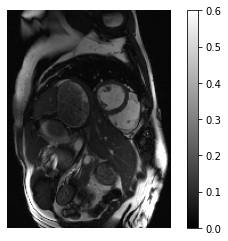

In [14]:
# Show the reconstructed cine image
from IPython.display import clear_output
import time

slc_idx = 2 # math.floor(SLC/2)
print(slc_idx)
image_slc = np.squeeze(image[:,:,:,:,:,slc_idx,:])/image[:,:,:,:,:,slc_idx,:].max()
print(image_slc.shape)
# image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx])
for rep in range(5): # repeate the movie for 5 times
    for frame in range(image_slc.shape[2]):
        clear_output(wait=True)
        plt.imshow(image_slc[:,:,frame], vmin=0, vmax=0.6*np.amax(image_slc), cmap = 'gray',origin='lower')
        plt.axis('off')
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)

In [ ]:
savepath = '/mnt/shared_a/OCMR/OCMR_fully_sampled_images/'
for fileind in range(len(regular_files)):
    filename    = regular_files[fileind][0]
    kData,param = read.read_ocmr(datapath+file)
    kData_tmp   = np.mean(kData, axis = 8); # average the k-space if average > 1

    im_coil = transform.transform_kspace_to_image(kData_tmp, [0,1]); # IFFT (2D image)
    im_sos  = np.sqrt(np.sum(np.abs(im_coil) ** 2, 3)) # Sum of Square
    print('Dimension of Image (with ReadOut ovesampling): ', im_sos.shape)
    RO    = im_sos.shape[0]
    image = im_sos[math.floor(RO/4):math.floor(RO/4*3),:,:] # Remove RO oversampling
    print('Dimension of Image (without ReadOout ovesampling): ', image.shape)
    
    for sliceind in range(image.shape[5]):
        image[:,:,:,:,:,sliceind,:] /= image[:,:,:,:,:,sliceind,:].max()
    
    torch.save(torch.tensor(image) , savepath + filename[:-3] + '.pt')
    print(f'file {savepath + filename} is successfully saved')

In [ ]:
datapath = '/mnt/shared_a/OCMR/OCMR_fully_sampled_images/'
file = 'fs_0074_1_5T.pt'
data = torch.load(datapath+file)

In [ ]:
slc_idx = 6 # math.floor(SLC/2)
print(slc_idx)
# image_slc = np.squeeze(image[:,:,:,:,:,slc_idx,:])/image[:,:,:,:,:,slc_idx,:].max()
# print(image_slc.shape)
# image_slc = np.squeeze(image[:,:,:,:,:,:,slc_idx])
for rep in range(3): # repeat the movie for 5 times
    for frame in range(data.shape[3]):
        clear_output(wait=True)
        plt.imshow(data[:,:,0,frame,0,slc_idx,:], vmin=0, vmax=data.max(), cmap = 'gray'); plt.axis('off');
        plt.colorbar()
        plt.show() 
        time.sleep(0.03)